In [1]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import os
import polars as pl
import yaml

In [2]:
PLOT_DIR = "../../results/plots/score_overlap/"
os.makedirs(PLOT_DIR, exist_ok=True)

with open('../../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
palette = {    
    "GPN-Star (V)": '#2773BA',
    "GPN-Star (M)": '#4F97DB',
    "GPN-Star (P)": '#95BFE6',
    
    "GPN-MSA": "#919191",
    "CADD": "#E09D5A",
    
    "PhyloP (V)": "#9E66BA",
    "PhastCons (V)": "#C4494B",
    "PhyloP (M)": "#B684D9",
    "PhastCons (M)": "#D96C70",
    "PhyloP (P)": "#D4A6ED",
    "PhastCons (P)": "#EDA8A6",

    "Enformer": "#B58181",

    "Ensemble": "black",
}

In [4]:
V = pl.read_parquet("../../results/variants/merged.annot_with_cre_v2.parquet", columns=["consequence"])
MAF = pl.read_parquet("../../results/maf/merged.parquet")
assert len(V) == len(MAF)
V = pl.concat([V, MAF], how="horizontal").with_columns(common=pl.col("MAF") > 5/100).drop("MAF")
V

consequence,common
str,bool
"""pELS-flank""",true
"""pELS-flank""",true
"""intron_variant""",true
"""intron_variant""",true
"""intron_variant""",true
…,…
"""non_coding_transcript_exon_var…",true
"""non_coding_transcript_exon_var…",false
"""intergenic_variant""",false


In [6]:
models = {
    "GPN-Star (P)": config["gpn_star_p"],
    "GPN-Star (M)": config["gpn_star_m"],
    "GPN-Star (V)": config["gpn_star_v"],
}
approach = "quantile"
q = 0.001

for name, model in models.items():
    V = V.with_columns(
        pl.read_parquet(
            f"../../results/variant_scores/{approach}/{model}/{q}.parquet",
        )["score"].eq(1).alias(name)
    )
V

consequence,common,GPN-Star (P),GPN-Star (M),GPN-Star (V)
str,bool,bool,bool,bool
"""pELS-flank""",true,false,false,false
"""pELS-flank""",true,false,false,false
"""intron_variant""",true,false,false,false
"""intron_variant""",true,false,false,false
"""intron_variant""",true,false,false,false
…,…,…,…,…
"""non_coding_transcript_exon_var…",true,false,false,false
"""non_coding_transcript_exon_var…",false,false,false,false
"""intergenic_variant""",false,false,false,false


In [7]:
V2 = {model: set(V[model].arg_true()) for model in models}
{k: len(v) for k, v in V2.items()}

{'GPN-Star (P)': 16108, 'GPN-Star (M)': 16499, 'GPN-Star (V)': 15401}

In [8]:
def plot(V, save_path=None):
    print({k: len(v) for k, v in V.items()})
    plt.figure(figsize=(2, 2))
    subsets = V.values()
    set_labels = V.keys()
    set_colors = tuple(palette[label] for label in set_labels)
    venn = venn3(subsets, set_labels=set_labels, set_colors=set_colors)
    if save_path is not None:
        for ext in [".svg", ".pdf"]:
            plt.savefig(PLOT_DIR + save_path + ext, bbox_inches="tight")

{'GPN-Star (P)': 16108, 'GPN-Star (M)': 16499, 'GPN-Star (V)': 15401}


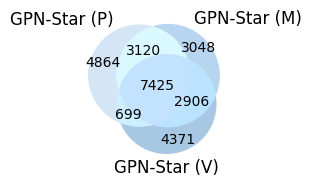

In [9]:
plot(V2, "all")

{'GPN-Star (P)': 5961, 'GPN-Star (M)': 5961, 'GPN-Star (V)': 5961}


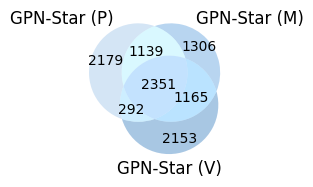

In [10]:
plot(
    {
        model: set((V[model] & V["common"]).arg_true())
        for model in models
    },
    "common",
)